In [45]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_score, recall_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
# 1. 数据预处理
def load_data(data_path):
    df = pd.read_csv(data_path)  # 替换为您的数据集路径
    X = df.iloc[:, :-1].values  # 特征向量
    y = df.iloc[:, -1].values  # 标签

    # 标准化特征向量
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data(r'C:\Users\MYZ\PycharmProjects\毕设实验\组织切片数据集\数据.csv')  # 替换为您的数据集路径

# 2. 定义自定义数据集类
class FeatureDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx] if self.y is not None else None

        if self.transform:
            x = self.transform(x)

        if y is not None:
            return x, y
        else:
            return x
# 3. 定义模型
class RegularizationTerm(nn.Module):
    def __init__(self, parameter):
        super(RegularizationTerm, self).__init__()
        self.parameter = parameter

    def forward(self):
        return torch.norm(self.parameter, 1)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, l2_reg=0.0, l1_reg=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # 添加L2正则化参数
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg

        # 创建正则化项
        self.regularization_terms = nn.ModuleList([
            RegularizationTerm(param) for param in self.parameters()
        ])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def regularization(self):
        # 计算L1和L2正则化项
        l1 = sum(regularization_term.forward() for regularization_term in self.regularization_terms)
        l2 = self.l2_reg * sum(torch.norm(param, 2) for param in self.parameters())

        return self.l1_reg * l1 + self.l2_reg * l2

input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(np.unique(y_train))  # 假设标签是离散的，根据实际情况调整
l2_reg = 0.001  # 设置L2正则化系数
l1_reg = 0.0  # 设置L1正则化系数（可选，一般L2正则化更常见）
model = MLP(input_dim, hidden_dim, output_dim, l2_reg=l2_reg, l1_reg=l1_reg)

# 4. 定义训练函数
def train_epoch(model, dataloader, optimizer, device, l2_reg=0.0, l1_reg=0.0):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # 添加正则化项到损失函数
        loss = nn.CrossEntropyLoss()(model(inputs), labels) + model.regularization()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

# 5. 设置设备和数据加载器... (这部分保持不变)
# 6. 设置设备和数据加载器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = FeatureDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FeatureDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

loss_history = []

# 6. 训练模型
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_reg)  # 使用weight_decay参数实现L2正则化
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')
    loss_history.append(train_loss)

def evaluate(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # 用于存储预测概率，用于计算AUC

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)  # 获取预测概率
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities[:, 1].cpu().numpy())  # 对于二分类问题，取正类的概率

    # 计算各项指标
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_true, y_scores, multi_class='ovr' if output_dim > 2 else 'binary')
    except ValueError:
        # 如果是多分类但非二分类，且没有实现ovo/ovr策略，或者数据不平衡导致的问题，可以尝试其他方式或忽略AUC
        auc = "N/A"
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Test Recall (Weighted Average): {recall:.4f}')
    print(f'Test Precision (Weighted Average): {precision:.4f}')
    print(f'Test AUC: {auc}')
    print(f'Test F1 Score (Weighted Average): {f1:.4f}')

    return recall, precision, auc, f1, classification_report(y_true, y_pred)

test_recall, test_precision, test_auc, test_f1, report = evaluate(model, test_loader, device)
print(report)

Epoch 1, Train Loss: 0.3086
Epoch 2, Train Loss: 0.1338
Epoch 3, Train Loss: 0.0754
Epoch 4, Train Loss: 0.0515
Epoch 5, Train Loss: 0.0329
Epoch 6, Train Loss: 0.0226
Epoch 7, Train Loss: 0.0193
Epoch 8, Train Loss: 0.0172
Epoch 9, Train Loss: 0.0191
Epoch 10, Train Loss: 0.0254
Epoch 11, Train Loss: 0.0448
Epoch 12, Train Loss: 0.0329
Epoch 13, Train Loss: 0.0303
Epoch 14, Train Loss: 0.0079
Epoch 15, Train Loss: 0.0037
Epoch 16, Train Loss: 0.0021
Epoch 17, Train Loss: 0.0020
Epoch 18, Train Loss: 0.0022
Epoch 19, Train Loss: 0.0024
Epoch 20, Train Loss: 0.0027
Epoch 21, Train Loss: 0.0029
Epoch 22, Train Loss: 0.0032
Epoch 23, Train Loss: 0.0034
Epoch 24, Train Loss: 0.0044
Epoch 25, Train Loss: 0.0049
Epoch 26, Train Loss: 0.0057
Epoch 27, Train Loss: 0.1518
Epoch 28, Train Loss: 0.2203
Epoch 29, Train Loss: 0.0414
Epoch 30, Train Loss: 0.0134
Epoch 31, Train Loss: 0.0080
Epoch 32, Train Loss: 0.0043
Epoch 33, Train Loss: 0.0028
Epoch 34, Train Loss: 0.0026
Epoch 35, Train Loss: 0

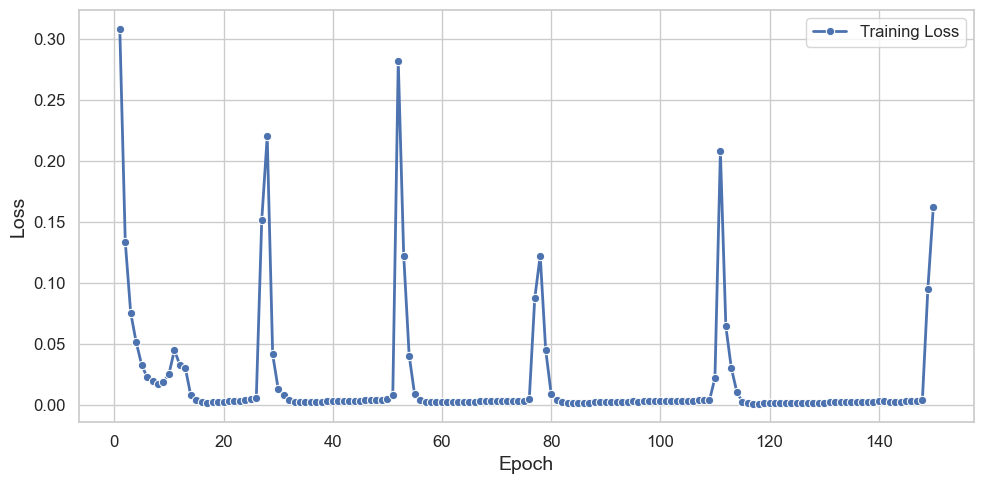

Chart saved as training_loss_形态学.png


'确认'

<Figure size 640x480 with 0 Axes>

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
# 使用Seaborn绘制图表
# 使用Seaborn绘制损失曲线
sns.set(style="whitegrid")  # 设置Seaborn风格
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs + 1), y=loss_history, marker='o', lw=2)  # 绘制线形图，设置线条宽度和标记点

plt.title('')  # 设置图表标题和字体大小
plt.xlabel('Epoch', fontsize=14)  # 设置x轴标签和字体大小
plt.ylabel('Loss', fontsize=14)  # 设置y轴标签和字体大小
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(['Training Loss'], loc='upper right', fontsize=12)  # 设置图例

plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()

# 保存图表到本地
output_filename = "training_loss_形态学.png"
plt.savefig(output_filename, dpi=300, pad_inches=0.1)
print(f"Chart saved as {output_filename}")

# 等待用户确认
input("Press Enter to continue...")

In [40]:
#Dropout正则化
import numpy as np
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_score, recall_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
# 1. 数据预处理
def load_data(data_path):
    df = pd.read_csv(data_path)  # 替换为您的数据集路径
    X = df.iloc[:, :-1].values  # 特征向量
    y = df.iloc[:, -1].values  # 标签

    # 标准化特征向量
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data(r'C:\Users\MYZ\PycharmProjects\毕设实验\组织切片数据集\数据.csv')  # 替换为您的数据集路径

# 2. 定义自定义数据集类
class FeatureDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx] if self.y is not None else None

        if self.transform:
            x = self.transform(x)

        if y is not None:
            return x, y
        else:
            return x
# 3. 定义模型
class RegularizationTerm(nn.Module):
    def __init__(self, parameter):
        super(RegularizationTerm, self).__init__()
        self.parameter = parameter

    def forward(self):
        return torch.norm(self.parameter, 1)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p=dropout_rate)  # 添加Dropout层
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # 应用Dropout
        x = self.fc2(x)
        return x


    def regularization(self):
        # 计算L1和L2正则化项
        l1 = sum(regularization_term.forward() for regularization_term in self.regularization_terms)
        l2 = self.l2_reg * sum(torch.norm(param, 2) for param in self.parameters())

        return self.l1_reg * l1 + self.l2_reg * l2

input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(np.unique(y_train))  # 假设标签是离散的，根据实际情况调整
l2_reg = 0.001  # 设置L2正则化系数
l1_reg = 0.0  # 设置L1正则化系数（可选，一般L2正则化更常见）
model = MLP(input_dim, hidden_dim, output_dim )

# 4. 定义训练函数
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = nn.CrossEntropyLoss()(model(inputs), labels)  # 移除正则化项
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


# 5. 设置设备和数据加载器... (这部分保持不变)
# 6. 设置设备和数据加载器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = FeatureDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FeatureDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

loss_history = []

# 6. 训练模型
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_reg)  # 使用weight_decay参数实现L2正则化
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')
    loss_history.append(train_loss)

def evaluate(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # 用于存储预测概率，用于计算AUC

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)  # 获取预测概率
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities[:, 1].cpu().numpy())  # 对于二分类问题，取正类的概率

    # 计算各项指标
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_true, y_scores, multi_class='ovr' if output_dim > 2 else 'binary')
    except ValueError:
        # 如果是多分类但非二分类，且没有实现ovo/ovr策略，或者数据不平衡导致的问题，可以尝试其他方式或忽略AUC
        auc = "N/A"
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Test Recall (Weighted Average): {recall:.4f}')
    print(f'Test Precision (Weighted Average): {precision:.4f}')
    print(f'Test AUC: {auc}')
    print(f'Test F1 Score (Weighted Average): {f1:.4f}')

    return recall, precision, auc, f1, classification_report(y_true, y_pred)

test_recall, test_precision, test_auc, test_f1, report = evaluate(model, test_loader, device)
print(report)

Epoch 1, Train Loss: 0.3489
Epoch 2, Train Loss: 0.1904
Epoch 3, Train Loss: 0.1340
Epoch 4, Train Loss: 0.1173
Epoch 5, Train Loss: 0.1070
Epoch 6, Train Loss: 0.0868
Epoch 7, Train Loss: 0.0736
Epoch 8, Train Loss: 0.0660
Epoch 9, Train Loss: 0.0544
Epoch 10, Train Loss: 0.0543
Epoch 11, Train Loss: 0.0697
Epoch 12, Train Loss: 0.0492
Epoch 13, Train Loss: 0.0466
Epoch 14, Train Loss: 0.0419
Epoch 15, Train Loss: 0.0423
Epoch 16, Train Loss: 0.0432
Epoch 17, Train Loss: 0.0522
Epoch 18, Train Loss: 0.0568
Epoch 19, Train Loss: 0.0485
Epoch 20, Train Loss: 0.0410
Epoch 21, Train Loss: 0.0406
Epoch 22, Train Loss: 0.0345
Epoch 23, Train Loss: 0.0349
Epoch 24, Train Loss: 0.0435
Epoch 25, Train Loss: 0.0445
Epoch 26, Train Loss: 0.0309
Epoch 27, Train Loss: 0.0408
Epoch 28, Train Loss: 0.0365
Epoch 29, Train Loss: 0.0330
Epoch 30, Train Loss: 0.0463
Epoch 31, Train Loss: 0.0433
Epoch 32, Train Loss: 0.0390
Epoch 33, Train Loss: 0.0469
Epoch 34, Train Loss: 0.0462
Epoch 35, Train Loss: 0

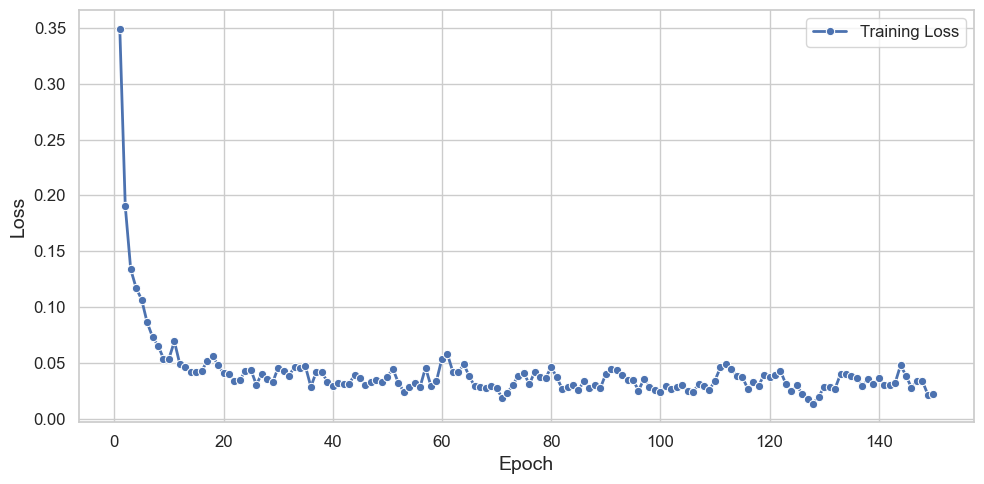

Chart saved as training_loss_形态学.png


'确认'

<Figure size 640x480 with 0 Axes>

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
# 使用Seaborn绘制图表
# 使用Seaborn绘制损失曲线
sns.set(style="whitegrid")  # 设置Seaborn风格
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs + 1), y=loss_history, marker='o', lw=2)  # 绘制线形图，设置线条宽度和标记点

plt.title('')  # 设置图表标题和字体大小
plt.xlabel('Epoch', fontsize=14)  # 设置x轴标签和字体大小
plt.ylabel('Loss', fontsize=14)  # 设置y轴标签和字体大小
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(['Training Loss'], loc='upper right', fontsize=12)  # 设置图例

plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()

# 保存图表到本地
output_filename = "training_loss_形态学.png"
plt.savefig(output_filename, dpi=300, pad_inches=0.1)
print(f"Chart saved as {output_filename}")

# 等待用户确认
input("Press Enter to continue...")

In [43]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_score, recall_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn.functional as F
# 1. 数据预处理
def load_data(data_path):
    df = pd.read_csv(data_path)  # 替换为您的数据集路径
    X = df.iloc[:, :-1].values  # 特征向量
    y = df.iloc[:, -1].values  # 标签

    # 标准化特征向量
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data(r'C:\Users\MYZ\PycharmProjects\毕设实验\组织切片数据集\数据.csv')  # 替换为您的数据集路径

# 2. 定义自定义数据集类
class FeatureDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx] if self.y is not None else None

        if self.transform:
            x = self.transform(x)

        if y is not None:
            return x, y
        else:
            return x
# 3. 定义模型
class RegularizationTerm(nn.Module):
    def __init__(self, parameter):
        super(RegularizationTerm, self).__init__()
        self.parameter = parameter

    def forward(self):
        return torch.norm(self.parameter, 1)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(np.unique(y_train))  # 假设标签是离散的，根据实际情况调整
l1_reg = 0.001  # 设置L1正则化系数
l2_reg = 0.0  # 设置L2正则化系数（可选，一般L2正则化更常见）
model = MLP(input_dim, hidden_dim, output_dim)


def regularization(self):
        # 计算L1和L2正则化项
        l1 = sum(regularization_term.forward() for regularization_term in self.regularization_terms)
        l2 = self.l2_reg * sum(torch.norm(param, 2) for param in self.parameters())

        return self.l1_reg * l1 + self.l2_reg * l2

input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(np.unique(y_train))  # 假设标签是离散的，根据实际情况调整
l2_reg = 0.001  # 设置L2正则化系数
l1_reg = 0.0  # 设置L1正则化系数（可选，一般L2正则化更常见）
model = MLP(input_dim, hidden_dim, output_dim )

# 4. 定义训练函数
def train_epoch(model, dataloader, optimizer, device, l1_reg, l2_reg=0.0):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # 计算L1和L2正则化项
        reg_loss = l1_reg * sum(torch.norm(param, 1) for param in model.parameters()) + l2_reg * sum(torch.norm(param, 2) for param in model.parameters())
        
        # 将正则化项添加到损失函数中
        total_loss = loss + reg_loss
        
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


# 5. 设置设备和数据加载器... (这部分保持不变)
# 6. 设置设备和数据加载器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = FeatureDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FeatureDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

loss_history = []

# 6. 训练模型
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 不再使用weight_decay参数
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device, l1_reg=l1_reg)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')
    loss_history.append(train_loss)

def evaluate(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # 用于存储预测概率，用于计算AUC

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)  # 获取预测概率
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities[:, 1].cpu().numpy())  # 对于二分类问题，取正类的概率

    # 计算各项指标
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_true, y_scores, multi_class='ovr' if output_dim > 2 else 'binary')
    except ValueError:
        # 如果是多分类但非二分类，且没有实现ovo/ovr策略，或者数据不平衡导致的问题，可以尝试其他方式或忽略AUC
        auc = "N/A"
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Test Recall (Weighted Average): {recall:.4f}')
    print(f'Test Precision (Weighted Average): {precision:.4f}')
    print(f'Test AUC: {auc}')
    print(f'Test F1 Score (Weighted Average): {f1:.4f}')

    return recall, precision, auc, f1, classification_report(y_true, y_pred)

test_recall, test_precision, test_auc, test_f1, report = evaluate(model, test_loader, device)
print(report)

Epoch 1, Train Loss: 0.3452
Epoch 2, Train Loss: 0.1942
Epoch 3, Train Loss: 0.1353
Epoch 4, Train Loss: 0.1186
Epoch 5, Train Loss: 0.0975
Epoch 6, Train Loss: 0.0735
Epoch 7, Train Loss: 0.0616
Epoch 8, Train Loss: 0.0629
Epoch 9, Train Loss: 0.0477
Epoch 10, Train Loss: 0.0395
Epoch 11, Train Loss: 0.0392
Epoch 12, Train Loss: 0.0390
Epoch 13, Train Loss: 0.0411
Epoch 14, Train Loss: 0.0402
Epoch 15, Train Loss: 0.0242
Epoch 16, Train Loss: 0.0289
Epoch 17, Train Loss: 0.0283
Epoch 18, Train Loss: 0.0290
Epoch 19, Train Loss: 0.0267
Epoch 20, Train Loss: 0.0353
Epoch 21, Train Loss: 0.0293
Epoch 22, Train Loss: 0.0314
Epoch 23, Train Loss: 0.0223
Epoch 24, Train Loss: 0.0191
Epoch 25, Train Loss: 0.0183
Epoch 26, Train Loss: 0.0172
Epoch 27, Train Loss: 0.0175
Epoch 28, Train Loss: 0.0184
Epoch 29, Train Loss: 0.0200
Epoch 30, Train Loss: 0.0148
Epoch 31, Train Loss: 0.0188
Epoch 32, Train Loss: 0.0139
Epoch 33, Train Loss: 0.0155
Epoch 34, Train Loss: 0.0254
Epoch 35, Train Loss: 0

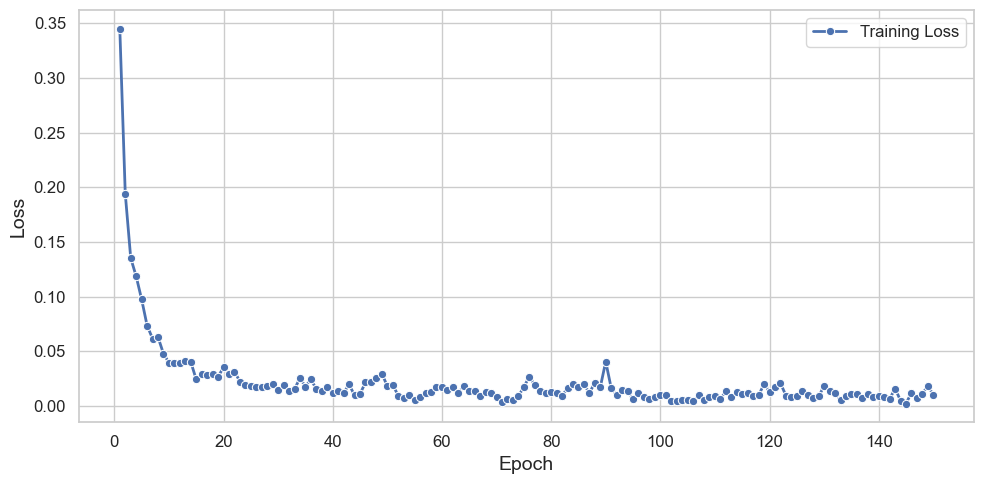

Chart saved as training_loss_形态学.png


'确认'

<Figure size 640x480 with 0 Axes>

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
# 使用Seaborn绘制图表
# 使用Seaborn绘制损失曲线
sns.set(style="whitegrid")  # 设置Seaborn风格
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs + 1), y=loss_history, marker='o', lw=2)  # 绘制线形图，设置线条宽度和标记点

plt.title('')  # 设置图表标题和字体大小
plt.xlabel('Epoch', fontsize=14)  # 设置x轴标签和字体大小
plt.ylabel('Loss', fontsize=14)  # 设置y轴标签和字体大小
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(['Training Loss'], loc='upper right', fontsize=12)  # 设置图例

plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()

# 保存图表到本地
output_filename = "training_loss_形态学.png"
plt.savefig(output_filename, dpi=300, pad_inches=0.1)
print(f"Chart saved as {output_filename}")

# 等待用户确认
input("Press Enter to continue...")